In [182]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import cv2
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import sys
import time
import timm
from PIL import Image
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau


In [183]:
def set_seed(seed=1220):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # If using GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [184]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)
print("You are using PyTorch version: %s" % torch.__version__)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# define class names
classes = ('A','B','C')

path_dataset = 'damage-classification-beam/dataset_beam/beam_damage'

You are using device: cuda
You are using PyTorch version: 2.5.1+cu118


In [185]:
def load_dataset(path_dataset):
    transform_train = transforms.Compose([
        transforms.Resize([224, 224]),   # Resize first
        transforms.RandomChoice([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        ]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
    ])
    
    # Data transformations for testing
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
    ])
    
    # load custom dataset
    full_dataset = torchvision.datasets.ImageFolder(
        root=path_dataset,
        transform=transform_train
    )
    
    # Split dataset into training and validation sets (8:2)
    dataset_size = len(full_dataset)
    train_size = int(0.9 * dataset_size)
    val_size = dataset_size - train_size
    
    trainset, valset = random_split(full_dataset, [train_size, val_size])
    
    # Create data loaders
    trainloader = DataLoader(
        trainset, batch_size=60, shuffle=True, num_workers=2
    )
    
    valloader = DataLoader(
        valset, batch_size=60, shuffle=True, num_workers=2
    )
    
    
    # Map folder names to class names
    class_map = {i: full_dataset.classes[i] for i in range(len(full_dataset.classes))}
    print(f"Dataset classes: {class_map}")

    global classes
    if len(full_dataset.classes) == len(classes):
        print("Using predefined class names")
    else:
        print("Using classes from dataset folder structure")
        classes = full_dataset.classes
    
    return trainloader, valloader

# Load dataset
trainloader, valloader = load_dataset(path_dataset)

Dataset classes: {0: 'Class A', 1: 'Class B', 2: 'Class C'}
Using predefined class names


In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch
import numpy as np
from tqdm import tqdm
import random

# ----------------- Hybrid ResNet50 --------------------
def get_resnet50_hybrid_model(num_classes, freeze=True):
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    if freeze:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
    return model

# ----------------- MixUp Functions --------------------
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ----------------- Seed Function --------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# ----------------- Training Loop --------------------
def train(model, trainloader, valloader, max_epochs=50, patience=10, min_delta=0.01, mixup_alpha=0.4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = model.state_dict()

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(max_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(enumerate(trainloader), total=len(trainloader), leave=True)

        for i, data in loop:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Apply MixUp
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=mixup_alpha)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (lam * (predicted == targets_a).sum().item() + (1 - lam) * (predicted == targets_b).sum().item())
            running_loss += loss.item()

            loop.set_description(f"Epoch [{epoch+1}/{max_epochs}]")
            loop.set_postfix(loss=running_loss/(i+1), accuracy=100.*correct/total)

        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # ---------- Validation ----------
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(valloader)
        epoch_val_acc = 100. * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        scheduler.step(epoch_val_loss)

        print(f"\nEpoch {epoch+1}/{max_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}%")
        print(f"Val   Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%")
        print("-" * 60)

        # Save best model
        if epoch_val_loss + min_delta < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_wts = model.state_dict()
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    print("Finished Training")
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

# ----------------- Example Usage --------------------
set_seed(1220)

num_classes = 3  # change to your dataset
model = get_resnet50_hybrid_model(num_classes, freeze=True).to(device)

# Phase 1: Train only fc layer
model, _, _, _, _ = train(model, trainloader, valloader, max_epochs=5, patience=3)

# Phase 2: Unfreeze all and fine-tune
for param in model.parameters():
    param.requires_grad = True

# Use lower LR when fine-tuning the full model
for g in torch.optim.AdamW(model.parameters()).param_groups:
    g['lr'] = 1e-5

model, train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, trainloader, valloader, max_epochs=50, patience=10, mixup_alpha=0.4
)


TypeError: train() missing 1 required positional argument: 'device'

In [187]:
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch
import numpy as np
from tqdm import tqdm
import random

# ----------------- Hybrid ResNet50 --------------------
def get_resnet50_hybrid_model(num_classes, freeze=True):
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    if freeze:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
    return model

# ----------------- MixUp Functions --------------------
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ----------------- Seed Function --------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# ----------------- Training Loop --------------------
def train(model, trainloader, valloader, max_epochs=50, patience=10, min_delta=0.01, mixup_alpha=0.4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = model.state_dict()

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(max_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(enumerate(trainloader), total=len(trainloader), leave=True)

        for i, data in loop:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Apply MixUp
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=mixup_alpha)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (lam * (predicted == targets_a).sum().item() + (1 - lam) * (predicted == targets_b).sum().item())
            running_loss += loss.item()

            loop.set_description(f"Epoch [{epoch+1}/{max_epochs}]")
            loop.set_postfix(loss=running_loss/(i+1), accuracy=100.*correct/total)

        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # ---------- Validation ----------
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(valloader)
        epoch_val_acc = 100. * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        scheduler.step(epoch_val_loss)

        print(f"\nEpoch {epoch+1}/{max_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}%")
        print(f"Val   Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%")
        print("-" * 60)

        # Save best model
        if epoch_val_loss + min_delta < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_wts = model.state_dict()
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    print("Finished Training")
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

# ----------------- Example Usage --------------------
set_seed(1220)

num_classes = 3  # change to your dataset
model = get_resnet50_hybrid_model(num_classes, freeze=True).to(device)

# Phase 1: Train only fc layer
model, _, _, _, _ = train(model, trainloader, valloader, max_epochs=5, patience=3)

# Phase 2: Unfreeze all and fine-tune
for param in model.parameters():
    param.requires_grad = True

# Use lower LR when fine-tuning the full model
for g in torch.optim.AdamW(model.parameters()).param_groups:
    g['lr'] = 1e-5

model, train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, trainloader, valloader, max_epochs=50, patience=10, mixup_alpha=0.4
)


Epoch [1/5]: 100%|██████████| 7/7 [00:00<00:00, 16.19it/s, accuracy=41.6, loss=1.08]



Epoch 1/5
Train Loss: 1.0795, Acc: 41.63%
Val   Loss: 1.0066, Acc: 39.02%
------------------------------------------------------------


Epoch [2/5]: 100%|██████████| 7/7 [00:00<00:00, 16.73it/s, accuracy=50.8, loss=1.05] 



Epoch 2/5
Train Loss: 1.0483, Acc: 50.84%
Val   Loss: 0.9174, Acc: 65.85%
------------------------------------------------------------


Epoch [3/5]: 100%|██████████| 7/7 [00:00<00:00, 16.36it/s, accuracy=61.3, loss=0.937]



Epoch 3/5
Train Loss: 0.9373, Acc: 61.28%
Val   Loss: 0.9403, Acc: 46.34%
------------------------------------------------------------
No improvement for 1 epochs.


Epoch [4/5]: 100%|██████████| 7/7 [00:00<00:00, 17.02it/s, accuracy=54.4, loss=0.993]



Epoch 4/5
Train Loss: 0.9929, Acc: 54.44%
Val   Loss: 0.8716, Acc: 75.61%
------------------------------------------------------------


Epoch [5/5]: 100%|██████████| 7/7 [00:00<00:00, 16.43it/s, accuracy=67.1, loss=0.93] 



Epoch 5/5
Train Loss: 0.9304, Acc: 67.09%
Val   Loss: 0.8391, Acc: 70.73%
------------------------------------------------------------
Finished Training


Epoch [1/50]: 100%|██████████| 7/7 [00:00<00:00, 10.21it/s, accuracy=68.6, loss=0.734]



Epoch 1/50
Train Loss: 0.7336, Acc: 68.59%
Val   Loss: 0.9934, Acc: 60.98%
------------------------------------------------------------


Epoch [2/50]: 100%|██████████| 7/7 [00:00<00:00, 10.47it/s, accuracy=75.9, loss=0.724]



Epoch 2/50
Train Loss: 0.7244, Acc: 75.93%
Val   Loss: 1.2686, Acc: 41.46%
------------------------------------------------------------
No improvement for 1 epochs.


Epoch [3/50]: 100%|██████████| 7/7 [00:00<00:00, 10.33it/s, accuracy=71.7, loss=0.823]



Epoch 3/50
Train Loss: 0.8229, Acc: 71.67%
Val   Loss: 0.8526, Acc: 70.73%
------------------------------------------------------------


Epoch [4/50]: 100%|██████████| 7/7 [00:00<00:00, 10.51it/s, accuracy=76, loss=0.79]   



Epoch 4/50
Train Loss: 0.7903, Acc: 75.99%
Val   Loss: 0.6669, Acc: 78.05%
------------------------------------------------------------


Epoch [5/50]: 100%|██████████| 7/7 [00:00<00:00, 10.37it/s, accuracy=85.3, loss=0.61] 



Epoch 5/50
Train Loss: 0.6104, Acc: 85.28%
Val   Loss: 0.6879, Acc: 78.05%
------------------------------------------------------------
No improvement for 1 epochs.


Epoch [6/50]: 100%|██████████| 7/7 [00:00<00:00, 10.31it/s, accuracy=90.3, loss=0.393]



Epoch 6/50
Train Loss: 0.3929, Acc: 90.33%
Val   Loss: 0.5026, Acc: 75.61%
------------------------------------------------------------


Epoch [7/50]: 100%|██████████| 7/7 [00:00<00:00, 10.39it/s, accuracy=81.1, loss=0.599]



Epoch 7/50
Train Loss: 0.5991, Acc: 81.07%
Val   Loss: 0.7540, Acc: 70.73%
------------------------------------------------------------
No improvement for 1 epochs.


Epoch [8/50]: 100%|██████████| 7/7 [00:00<00:00, 10.54it/s, accuracy=85.9, loss=0.609]



Epoch 8/50
Train Loss: 0.6087, Acc: 85.95%
Val   Loss: 0.7166, Acc: 73.17%
------------------------------------------------------------
No improvement for 2 epochs.


Epoch [9/50]: 100%|██████████| 7/7 [00:00<00:00, 10.57it/s, accuracy=84.8, loss=0.562]



Epoch 9/50
Train Loss: 0.5616, Acc: 84.79%
Val   Loss: 0.7217, Acc: 68.29%
------------------------------------------------------------
No improvement for 3 epochs.


Epoch [10/50]: 100%|██████████| 7/7 [00:00<00:00, 10.33it/s, accuracy=72, loss=0.763]  



Epoch 10/50
Train Loss: 0.7629, Acc: 71.95%
Val   Loss: 0.7756, Acc: 65.85%
------------------------------------------------------------
No improvement for 4 epochs.


Epoch [11/50]: 100%|██████████| 7/7 [00:00<00:00, 10.48it/s, accuracy=85.8, loss=0.54] 



Epoch 11/50
Train Loss: 0.5397, Acc: 85.83%
Val   Loss: 0.4698, Acc: 78.05%
------------------------------------------------------------


Epoch [12/50]: 100%|██████████| 7/7 [00:00<00:00, 10.33it/s, accuracy=79, loss=0.57]   



Epoch 12/50
Train Loss: 0.5703, Acc: 78.98%
Val   Loss: 0.6968, Acc: 73.17%
------------------------------------------------------------
No improvement for 1 epochs.


Epoch [13/50]: 100%|██████████| 7/7 [00:00<00:00, 10.34it/s, accuracy=76.4, loss=0.659]



Epoch 13/50
Train Loss: 0.6589, Acc: 76.43%
Val   Loss: 0.7596, Acc: 70.73%
------------------------------------------------------------
No improvement for 2 epochs.


Epoch [14/50]: 100%|██████████| 7/7 [00:00<00:00, 10.51it/s, accuracy=86.1, loss=0.559]



Epoch 14/50
Train Loss: 0.5586, Acc: 86.11%
Val   Loss: 0.6435, Acc: 78.05%
------------------------------------------------------------
No improvement for 3 epochs.


Epoch [15/50]: 100%|██████████| 7/7 [00:00<00:00, 10.19it/s, accuracy=74.2, loss=0.846]



Epoch 15/50
Train Loss: 0.8464, Acc: 74.17%
Val   Loss: 0.7953, Acc: 68.29%
------------------------------------------------------------
No improvement for 4 epochs.


Epoch [16/50]: 100%|██████████| 7/7 [00:00<00:00, 10.28it/s, accuracy=77.7, loss=0.776]



Epoch 16/50
Train Loss: 0.7758, Acc: 77.71%
Val   Loss: 0.9514, Acc: 58.54%
------------------------------------------------------------
No improvement for 5 epochs.


Epoch [17/50]: 100%|██████████| 7/7 [00:00<00:00, 10.37it/s, accuracy=72.8, loss=0.754]



Epoch 17/50
Train Loss: 0.7538, Acc: 72.78%
Val   Loss: 0.7438, Acc: 65.85%
------------------------------------------------------------
No improvement for 6 epochs.


Epoch [18/50]: 100%|██████████| 7/7 [00:00<00:00, 10.63it/s, accuracy=81.5, loss=0.595]



Epoch 18/50
Train Loss: 0.5953, Acc: 81.48%
Val   Loss: 0.6443, Acc: 73.17%
------------------------------------------------------------
No improvement for 7 epochs.


Epoch [19/50]: 100%|██████████| 7/7 [00:00<00:00, 10.08it/s, accuracy=86, loss=0.473]  



Epoch 19/50
Train Loss: 0.4732, Acc: 86.05%
Val   Loss: 0.6880, Acc: 73.17%
------------------------------------------------------------
No improvement for 8 epochs.


Epoch [20/50]: 100%|██████████| 7/7 [00:00<00:00, 10.28it/s, accuracy=83.3, loss=0.585]



Epoch 20/50
Train Loss: 0.5854, Acc: 83.35%
Val   Loss: 0.6427, Acc: 73.17%
------------------------------------------------------------
No improvement for 9 epochs.


Epoch [21/50]: 100%|██████████| 7/7 [00:00<00:00, 10.32it/s, accuracy=84.1, loss=0.53] 



Epoch 21/50
Train Loss: 0.5296, Acc: 84.11%
Val   Loss: 0.5801, Acc: 75.61%
------------------------------------------------------------
No improvement for 10 epochs.
Early stopping triggered!
Finished Training


In [186]:
import torchvision.models as models

model = torchvision.models.densenet201()


for param in model.parameters():
    param.requires_grad = False  
for param in model.features.denseblock4.parameters():  # Last feature block
    param.requires_grad = True
for param in model.features.transition3.parameters():  # Optional: transition before block4
    param.requires_grad = True
for param in model.features.norm5.parameters():       # Final batch norm
    param.requires_grad = True


num_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.7),  
    nn.Linear(1024, 3)  
)

# Move to device
model = model.to(device)

In [133]:
from torchvision.models import resnet50, ResNet50_Weights

def get_resnet50_hybrid_model(num_classes, freeze=True):
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    
    # Replace final layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    # Freeze everything if freeze=True
    if freeze:
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze only fc layer
        for param in model.fc.parameters():
            param.requires_grad = True
            
    return model

num_classes = 3  # change to your target class count
model = get_resnet50_hybrid_model(num_classes)
model = model.to(device)


In [24]:
class EfficientNetB4Classifier(nn.Module):
    def __init__(self, num_classes=3):
        super(EfficientNetB4Classifier, self).__init__()
        self.model = timm.create_model("efficientnet_b4", pretrained=True)
        self.model.classifier = nn.Sequential(
            nn.Linear(self.model.classifier.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = EfficientNetB4Classifier(num_classes=3).to(device)


In [128]:
set_seed(1220)  # Set seed for reproducibility
def train(model,trainloader,valloader,max_epochs=50,patience=10,min_delta=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

    
    # Reduce LR on plateau of validation loss
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(max_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(enumerate(trainloader), total=len(trainloader), leave=True)

        for i, data in loop:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            loop.set_description(f"Epoch [{epoch+1}/{max_epochs}]")
            loop.set_postfix(loss=running_loss/(i+1), accuracy=100.*correct/total)

        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(valloader)
        epoch_val_acc = 100. * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        scheduler.step(epoch_val_loss)  # Updating Learning Rate scheduler

        print(f"\nEpoch {epoch+1}/{max_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}%")
        print(f"Val   Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%")
        print("-" * 60)

        # Implementing early stopping in training so that training can be stop when overfitting occurs
        if epoch_val_loss + min_delta < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_wts = model.state_dict()  # Save best weights
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    print("Finished Training")
    model.load_state_dict(best_model_wts)  # Load best weights
    return model, train_losses, train_accuracies, val_losses, val_accuracies


In [157]:
def Save_Model():
    torch.save(model.state_dict(), 'model.pth')
    print("Model saved successfully!")
    return

def Load_Model():
    model.load_state_dict(torch.load('model.pth'))
    model.eval()
    print("Model loaded successfully!")
    return

In [170]:
print("Starting training...")
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, trainloader, valloader
)

Starting training...


Epoch [1/50]: 100%|██████████| 7/7 [00:00<00:00, 10.44it/s, accuracy=73.2, loss=0.839]



Epoch 1/50
Train Loss: 0.8390, Acc: 73.24%
Val   Loss: 0.9244, Acc: 78.05%
------------------------------------------------------------


Epoch [2/50]: 100%|██████████| 7/7 [00:00<00:00, 10.34it/s, accuracy=70.7, loss=0.894]



Epoch 2/50
Train Loss: 0.8939, Acc: 70.74%
Val   Loss: 1.0949, Acc: 58.54%
------------------------------------------------------------
No improvement for 1 epochs.


Epoch [3/50]: 100%|██████████| 7/7 [00:00<00:00, 10.34it/s, accuracy=76.9, loss=0.833]



Epoch 3/50
Train Loss: 0.8332, Acc: 76.90%
Val   Loss: 0.8463, Acc: 65.85%
------------------------------------------------------------


Epoch [4/50]:  14%|█▍        | 1/7 [00:00<00:01,  3.36it/s, accuracy=76.3, loss=0.726]


KeyboardInterrupt: 

In [171]:
def evaluate(model, valloader):

    model.eval()
    correct = 0
    total = 0
    
    # Initialize lists for per-class accuracy
    num_classes = len(classes)
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    
    # Initialize confusion matrix
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.no_grad():
        for data in tqdm(valloader, desc="Evaluating"):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Calculate per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
                
                # Update confusion matrix
                confusion_matrix[label, predicted[i]] += 1

    overall_accuracy = 100 * correct / total
    print(f'Overall Accuracy: {overall_accuracy:.2f}%')

    
    return class_correct, class_total, confusion_matrix

In [172]:
print("Starting evaluating...")
class_correct, class_total, confusion_matrix = evaluate(trained_model, valloader)

Starting evaluating...


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

Overall Accuracy: 82.93%


In [154]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):

    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    fig.savefig('training_metrics.png')
    print("Training metrics plot saved as 'training_metrics.png'")
    return

In [155]:
def plot_evaluation_metrics(class_correct, class_total, confusion_matrix):

    num_classes = len(classes)
    
    # Calculate accuracies and identify valid classes
    accuracies = []
    valid_classes = []
    
    print("\nPer-class Accuracy:")
    print("-" * 50)
    for i in range(num_classes):
        if class_total[i] > 0:  # Avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
            accuracies.append(accuracy)
            valid_classes.append(classes[i])
        else:
            print(f'{classes[i]}: No samples')
    
    # Plot per-class accuracy as a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(valid_classes, accuracies, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-class Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('per_class_accuracy.png')
    plt.show()
    
    # Normalize confusion matrix by row (true labels) and plot
    normalized_confusion_matrix = confusion_matrix.clone()  # Create a copy to avoid modifying the original
    for i in range(num_classes):
        if normalized_confusion_matrix[i].sum() > 0:
            normalized_confusion_matrix[i] = normalized_confusion_matrix[i] / normalized_confusion_matrix[i].sum()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_confusion_matrix.cpu().numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
   
    thresh = normalized_confusion_matrix.cpu().numpy().max() / 2.0
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, f'{normalized_confusion_matrix[i, j]:.2f}',
                     horizontalalignment="center",
                     color="white" if normalized_confusion_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return

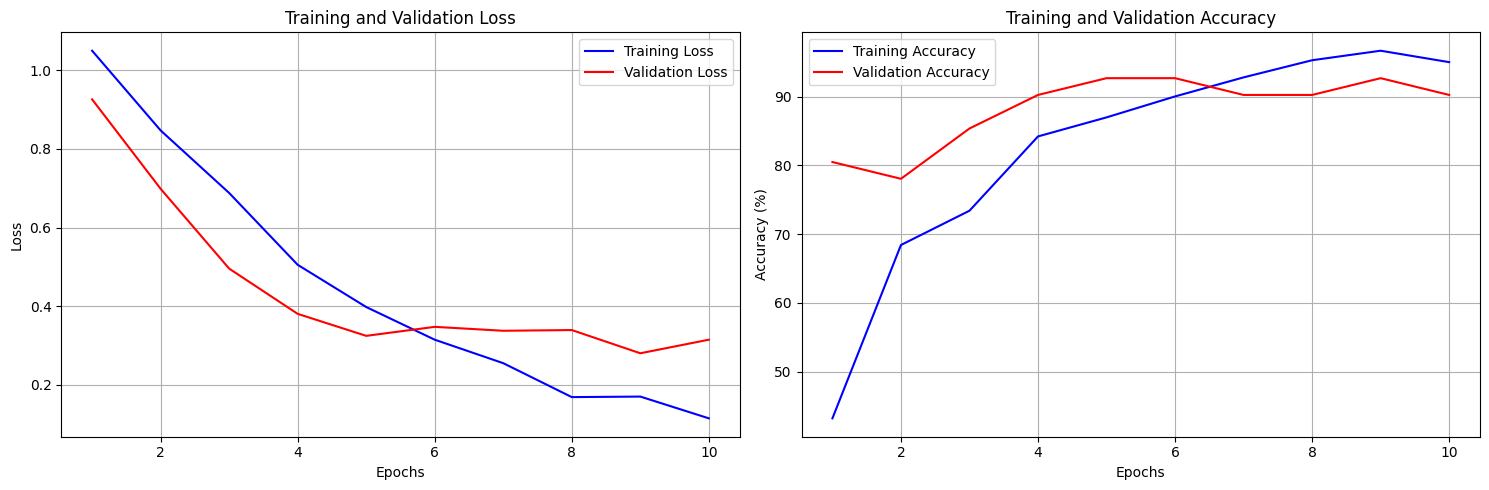

Training metrics plot saved as 'training_metrics.png'


In [ ]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)


Per-class Accuracy:
--------------------------------------------------
A: 94.12% (16/17)
B: 81.25% (13/16)
C: 87.50% (7/8)


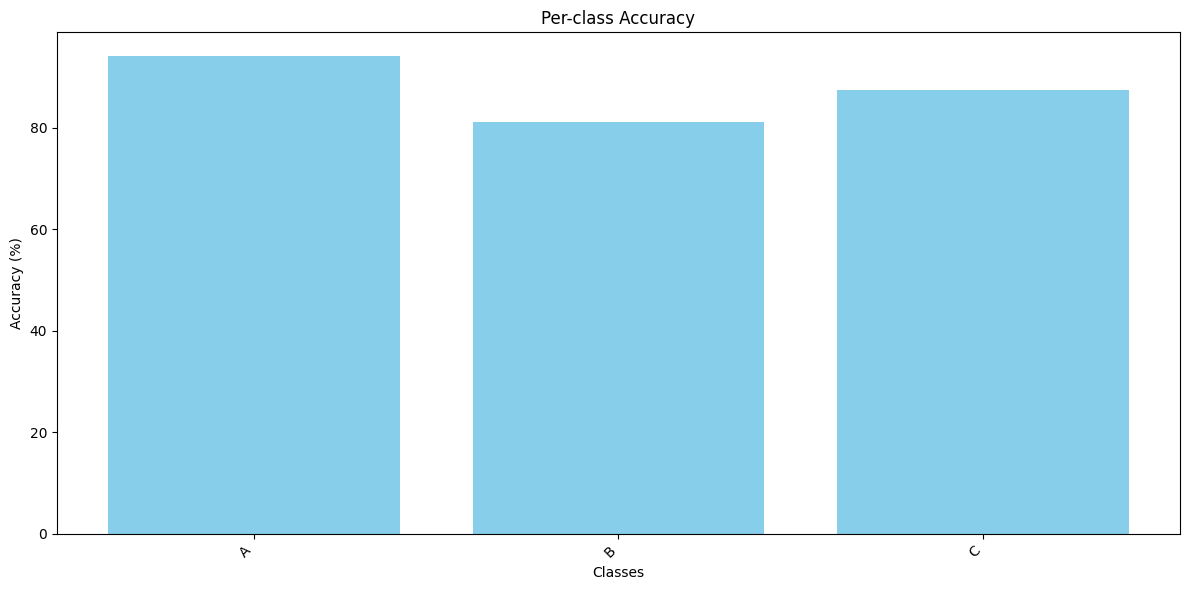

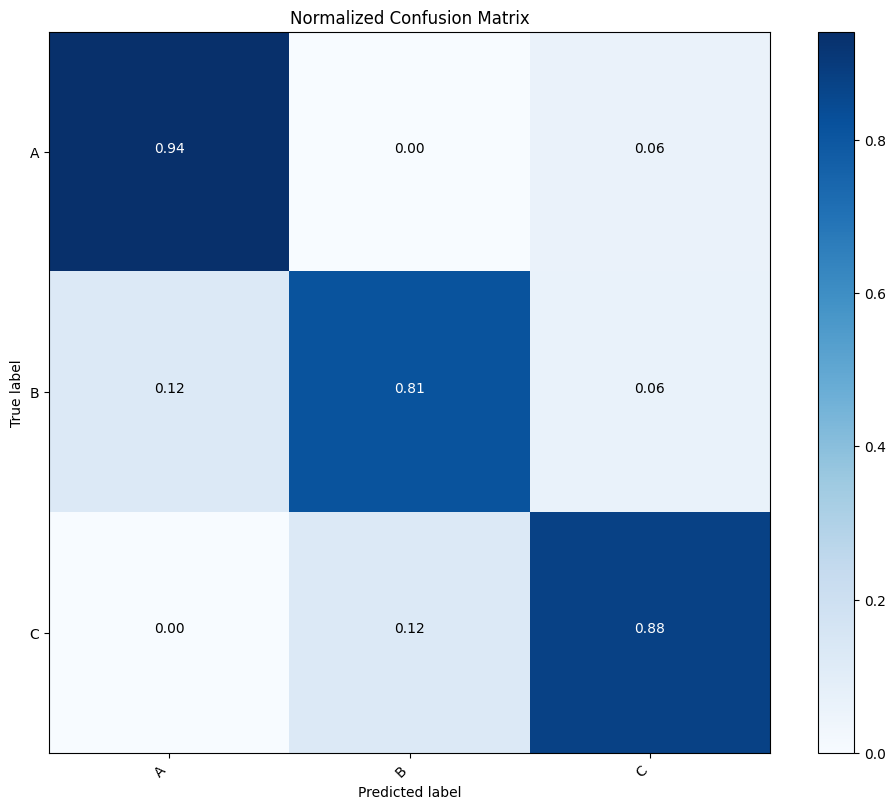

In [156]:
plot_evaluation_metrics(class_correct, class_total, confusion_matrix)

In [68]:
Save_Model()

Model saved successfully!


In [ ]:
import os
# Change this part to your path
test_folder_path=r"C:\Users\User\Downloads\damage-classification-beam\dataset_beam\test"       
csv_file_path= r"C:\Users\User\Downloads\damage-classification-beam\dataset_beam\submission_example.csv"
model_path="model.pth"
file_extension=".jpg"           


# Load CSV file
df = pd.read_csv(csv_file_path)
print(f"Loaded CSV with {len(df)} entries")

# Get column names
columns = df.columns.tolist()
first_col = columns[0]  # Image name column
second_col = columns[1]  # Empty column for predictions

# Load model
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Set up transformation (same as we set up earlier in the dataloaidng part, put I put here again for clarity)
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

label_map = {0: "A", 1: "B", 2: "C"}

for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        img_name = str(row[first_col]).strip()
        
        img_path = os.path.join(test_folder_path, img_name + file_extension)
               
        # Process the image
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        
        # Predict
        with torch.no_grad():
            output = model(img_tensor)
            _, predicted = torch.max(output.data, 1)
            predicted_idx = predicted.item()
        
        # Update CSV
        df.at[idx, second_col] = label_map[predicted_idx]
        
    except Exception as e:
        print(f"Error with image {img_name}: {e}")

# Save updated CSV
df.to_csv(csv_file_path, index=False)
print(f"Updated CSV saved to {csv_file_path}")


Loaded CSV with 100 entries


100%|██████████| 100/100 [00:28<00:00,  3.47it/s]

Updated CSV saved to C:\Users\User\Downloads\damage-classification-beam\dataset_beam\submission_example.csv


In [ ]:
python train.py --data beam_3class.yaml --img 640 --batch 16 --epochs 100 --weights {HOME}/weights/yolov9-c.pt --cfg models/detect/yolov9.yaml --hyp data/hyps/hyp.scratch-high.yaml --device 0

SyntaxError: invalid syntax (336199728.py, line 1)

In [ ]:
print("Starting evaluating...")
class_correct, class_total, confusion_matrix = evaluate(trained_model, valloader)

Starting evaluating...


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 14.75it/s]

Overall Accuracy: 78.05%


In [ ]:
yaml_content = """
train: /home/nobel0601/datasets/damage_detection/3class/for_training/datasets_3class_beam_shuffled/train/images
val: /home/nobel0601/datasets/damage_detection/3class/for_training/datasets_3class_beam_shuffled/val/images
test: /home/nobel0601/datasets/damage_detection/3class/for_training/datasets_3class_beam_shuffled/test/images

nc: 3
names: ['rebar', 'crack', 'spalling']
"""

with open("beam_3class.yaml", "w") as f:
    f.write(yaml_content)

#Train YOLOv9
cd /home/nobel0601/yolov9
python train_dual.py --data beam_3class.yaml --img 640 --batch 16 --epochs 100 --weights weights/yolov9-c.pt --cfg models/detect/yolov9-c.yaml --hyp data/hyps/hyp.scratch-high.yaml --device 0

#Inference YOLOv9
python /home/nobel0601/yolov9/detect_dual.py --weights /home/nobel0601/yolov9/runs/train/exp15/weights/best.pt --source /home/nobel0601/datasets/test_data/beam --img 640 --conf 0.25 --device 0 --save-txt --save-conf --project runs/detect --name predict --exist-ok


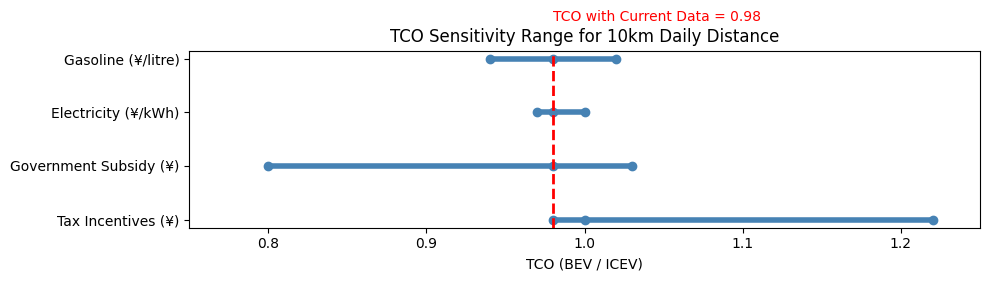

<Figure size 640x480 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt

# Labels and values
variables = ['Gasoline (¥/litre)', 'Electricity (¥/kWh)', 'Government Subsidy (¥)', 'Tax Incentives (¥)']
low_values = [0.94, 0.97, 0.8, 1.0]
normal_values = [0.98, 0.98, 0.98, 0.98]
high_values = [1.02, 1.00, 1.03, 1.22]

# Setup
fig, ax = plt.subplots(figsize=(10, 3))
y = range(len(variables))

# Draw lines from low to high
for i in y:
    x_values = [low_values[i], normal_values[i], high_values[i]]
    x_values.sort()  # Ensure line goes left to right
    ax.plot(x_values, [i]*3, marker='o', color='steelblue', linewidth=4)

# Reference line
ax.axvline(0.98, color='red', linestyle='--', linewidth=2)
ax.text(0.98, -0.7, 'TCO with Current Data = 0.98', color='red')

# Labels and styling
ax.set_yticks(y)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlim(0.75, 1.25)
ax.set_xlabel('TCO (BEV / ICEV)')
ax.set_title('TCO Sensitivity Range for 10km Daily Distance')

plt.tight_layout()
plt.show()
plt.savefig('tco_sensitivity_10km.png')


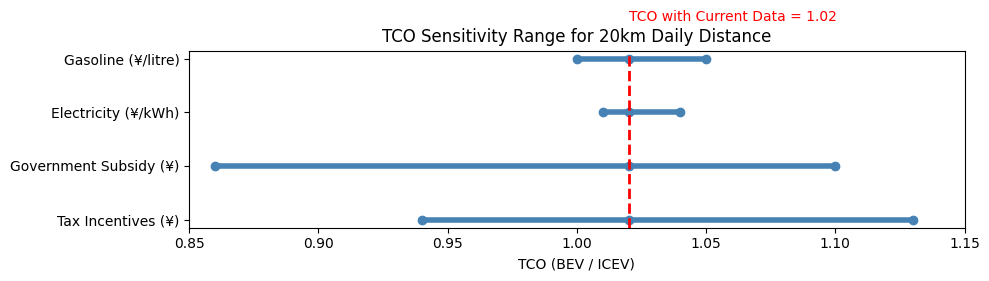

<Figure size 640x480 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt

# Labels and values
variables = ['Gasoline (¥/litre)', 'Electricity (¥/kWh)', 'Government Subsidy (¥)', 'Tax Incentives (¥)']
low_values = [1.00, 1.01, 0.86, 0.94]
normal_values = [1.02, 1.02, 1.02, 1.02]
high_values = [1.05, 1.04, 1.10, 1.13]

# Setup
fig, ax = plt.subplots(figsize=(10, 3))
y = range(len(variables))

# Draw lines from low to high
for i in y:
    x_values = [low_values[i], normal_values[i], high_values[i]]
    x_values.sort()  # Ensure line goes left to right
    ax.plot(x_values, [i]*3, marker='o', color='steelblue', linewidth=4)

# Reference line
ax.axvline(1.02, color='red', linestyle='--', linewidth=2)
ax.text(1.02, -0.7, 'TCO with Current Data = 1.02', color='red')

# Labels and styling
ax.set_yticks(y)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlim(0.85, 1.15)
ax.set_xlabel('TCO (BEV / ICEV)')
ax.set_title('TCO Sensitivity Range for 20km Daily Distance')

plt.tight_layout()
plt.show()
plt.savefig('tco_sensitivity_20km.png')


In [3]:
import matplotlib.pyplot as plt

# Labels and values
variables = ['Gasoline (¥/litre)', 'Electricity (¥/kWh)', 'Government Subsidy (¥)', 'Tax Incentives (¥)']
low_values = [1.06, 1.07, 0.93, 0.88]
normal_values = [1.07, 1.07, 1.07, 1.07]
high_values = [1.09, 1.08, 1.18, 1.05]

# Set desired figure size in inches (width, height)
fig, ax = plt.subplots(figsize=(5.87, 4.46))  # ← updated size

# Plot lines
y = range(len(variables))
for i in y:
    x_values = [low_values[i], normal_values[i], high_values[i]]
    x_values.sort()
    ax.plot(x_values, [i]*3, marker='o', color='steelblue', linewidth=4)

# Reference line
ax.axvline(1.07, color='red', linestyle='--', linewidth=2)
ax.text(1.07, -0.6, 'TCO with Current Data = 1.07', color='red', ha='left')

# Styling
ax.set_yticks(y)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlim(0.85, 1.20)
ax.set_xlabel('TCO (BEV / ICEV)')
ax.set_title('TCO Sensitivity Range for 30km Daily Distance')

plt.tight_layout()

# Save as PNG at high resolution (optional: dpi=300 for sharp PowerPoint)
plt.savefig('tco_sensitivity_30km.png', dpi=300)
plt.close()
plt.show()


In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
import os

# For reproduce the result
torch.manual_seed(1220)
random.seed(1220)
np.random.seed(1220)

# ----------------------------- CONFIG ----------------------------- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3
warmup_epochs = 10
finetune_epochs = 20
batch_size = 32

# ----------------------------- DATASET ----------------------------- #
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_path = '/home/nobel0601/datasets/crack_hough'  # e.g., './data/cracks'
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

# ----------------------------- MODEL ----------------------------- #
class CrackClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CrackClassifier, self).__init__()
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = CrackClassifier(num_classes=num_classes).to(device)

# ----------------------------- WARM-UP PHASE ----------------------------- #
# Freeze backbone
for param in model.model.parameters():
    param.requires_grad = False
for param in model.model.head.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()

print("\n===== Warm-up Phase =====")
for epoch in range(warmup_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{warmup_epochs}] Loss: {running_loss/len(train_loader):.4f}")

# ----------------------------- FINE-TUNING PHASE ----------------------------- #
# Unfreeze entire model
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

print("\n===== Fine-Tuning Phase =====")
for epoch in range(finetune_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{finetune_epochs}] Loss: {running_loss/len(train_loader):.4f}")

# ----------------------------- SAVE MODEL ----------------------------- #
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), "checkpoints/vit_finetuned.pth")
print("\nModel saved to checkpoints/vit_finetuned.pth")



===== Warm-up Phase =====
Epoch [1/10] Loss: 1.1434
Epoch [2/10] Loss: 0.9897
Epoch [3/10] Loss: 0.9079
Epoch [4/10] Loss: 0.8387
Epoch [5/10] Loss: 0.8626
Epoch [6/10] Loss: 0.8053
Epoch [7/10] Loss: 0.7631
Epoch [8/10] Loss: 0.7552
Epoch [9/10] Loss: 0.7402
Epoch [10/10] Loss: 0.7449

===== Fine-Tuning Phase =====
Epoch [1/20] Loss: 0.8132
Epoch [2/20] Loss: 0.4748
Epoch [3/20] Loss: 0.2828
Epoch [4/20] Loss: 0.1916
Epoch [5/20] Loss: 0.1420
Epoch [6/20] Loss: 0.1038
Epoch [7/20] Loss: 0.1088
Epoch [8/20] Loss: 0.1075
Epoch [9/20] Loss: 0.0933
Epoch [10/20] Loss: 0.0973
Epoch [11/20] Loss: 0.0976
Epoch [12/20] Loss: 0.0857
Epoch [13/20] Loss: 0.0871
Epoch [14/20] Loss: 0.0942
Epoch [15/20] Loss: 0.0959
Epoch [16/20] Loss: 0.1069
Epoch [17/20] Loss: 0.0968
Epoch [18/20] Loss: 0.0857
Epoch [19/20] Loss: 0.0865
Epoch [20/20] Loss: 0.0959

Model saved to checkpoints/vit_finetuned.pth


In [97]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

In [98]:
evaluate(model, valloader, device)


Accuracy: 58.54%


58.53658536585366